In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, lib
from dotenv import load_dotenv
import typing

load_dotenv()

In [2]:
"""
This code snippet reads data from Excel files and processes it. It collects system reliability data, dates, and a DataFrame containing specific columns.

Explanation:
1. The code initializes three empty lists: `sys`, `dat`, and `df`.
2. It searches for Excel files recursively in the current working directory.
3. For each file:
   a. Attempts to read data from the sheet named "System Reliability Data" using the openpyxl engine.
   b. Reads additional data from the same sheet, skipping the first 8 rows.
   c. Appends values from specific columns to the `sys` and `dat` lists.
   d. Extracts a DataFrame containing specific columns from the remaining data and appends it to the `df` list.
4. Any exceptions encountered during file processing are caught and ignored.

Note:
- This code assumes that the Excel files contain sheets named "System Reliability Data."
- Adjust the sheet names and column indices as needed for your specific data.
"""

sys, dat, df = [], [], []

for file in glob.glob(os.path.join(os.getcwd(), "**", "*.xlsx"), recursive=True):
    try:
        a = pd.read_excel(file, sheet_name="System Reliability Data", engine='openpyxl')
        b = pd.read_excel(file, sheet_name="System Reliability Data", engine='openpyxl', skiprows=8)
        sys.append(a["Unnamed: 2"][1])
        dat.append(a["Unnamed: 2"][2])
        df.append(pd.DataFrame(b.iloc[:,17:-1].iloc[1]).T)
    except:
        continue

In [3]:
"""
This code snippet concatenates and processes data from a DataFrame. It assigns specific columns and sorts the DataFrame by date.

Explanation:
1. The code concatenates DataFrames contained in the list `df`.
2. Two new columns are created in the resulting DataFrame: "Date" and "System."
3. Duplicate rows based on the "Date" column are removed.
4. The "Date" column is set as the index of the DataFrame.
5. The DataFrame is sorted in ascending order based on the date.

Note:
- Adjust column names and operations according to your specific data.
"""

raw_data: pd.DataFrame = pd.concat([df[j] for j in range(len(df))])
raw_data["Date"], raw_data["System"] = dat, sys
raw_data.index = raw_data["Date"]
data_co = raw_data.drop_duplicates().sort_index(ascending=True)

In [4]:
data_co["System"].value_counts()

System
Consumers Energy Co.                12
Upper Peninsula Power Co.           12
Northern States Power Co. (Xcel)    12
Alpena Power Co.                    12
DTE Energy Co.                      12
Name: count, dtype: int64

In [5]:
fields: typing.Dict[int, str] = {
    1: "Total Customer outages",
    2: "Total number of outages causes by equipment failure",
    3: "Total number of outages caused by lightning",
    4: "Total number of planned and forced outages",
    5: "Total number of outages caused by transmission or generation failure",
    6: "Total number of outages caused by an act of the public at large",
    7: "Total number of outages caused by trees",
    8: "Total number of outage caused by weather", # This
    9: "Total number of outages caued by animal interference",
    10: "Total number of outages caused by unknonwn causes", # This
    11: "Total number of outages caused by other causes", # This
    12: "System Average Interruption Duration Index", # ! SAIDI
    13: "System Average Interruption Frequency Index", # ! SAIFI
    14: "Customer Average Interruption Duration Index (contribution to total CAIDI)", # ! CAIDI
    15: "Average Service Availability Index",
    
    # ----------------------------------------------- |>
    
    16: "NII-Average",
    17: "NII-Sumatory",
    18: "NII-Median",

    # ----------------------------------------------- |>

    19: "SAIDI-Average",
    20: "SAIDI-Sumatory",
    21: "SAIDI-Median",

    # ----------------------------------------------- |>

    22: "SAIFI-Average",
    23: "SAIFI-Sumatory",
    24: "SAIFI-Median"
}

In [ ]:
for col_name in fields.values():  
    try:
        data_co[col_name.strip()] = data_co[col_name.strip()].astype(float).fillna(0)
    except KeyError:
        continue

try:
    data_co['Date'] = pd.to_datetime(data_co['Date']) 
except (KeyError, ValueError):  
    print("'date' column not found or invalid format. Skipping conversion.")

In [ ]:
ColumnList = typing.List[str]
Type = typing.Literal['average', 'sumatory', 'median']

def calculate_column(df: pd.DataFrame, col_name: str, cols: ColumnList, type: Type) -> typing.NoReturn:
    if type == 'sumatory':
        df[col_name.strip()] = df[cols].sum(axis=1)
        return
    
    if type == 'average':
        df[col_name.strip()] = df[cols].mean(axis=1)
        return

    if type == 'median':
        df[col_name.strip()] = df[cols].median(axis=1)
        return
    
    raise ValueError('type not specified')

In [ ]:
calculate_column(df=data_co, col_name=fields.get(16), cols=[fields.get(8), fields.get(10), fields.get(11)], type='average')
calculate_column(df=data_co, col_name=fields.get(17), cols=[fields.get(8), fields.get(10), fields.get(11)], type='sumatory')
calculate_column(df=data_co, col_name=fields.get(18), cols=[fields.get(8), fields.get(10), fields.get(11)], type='median')




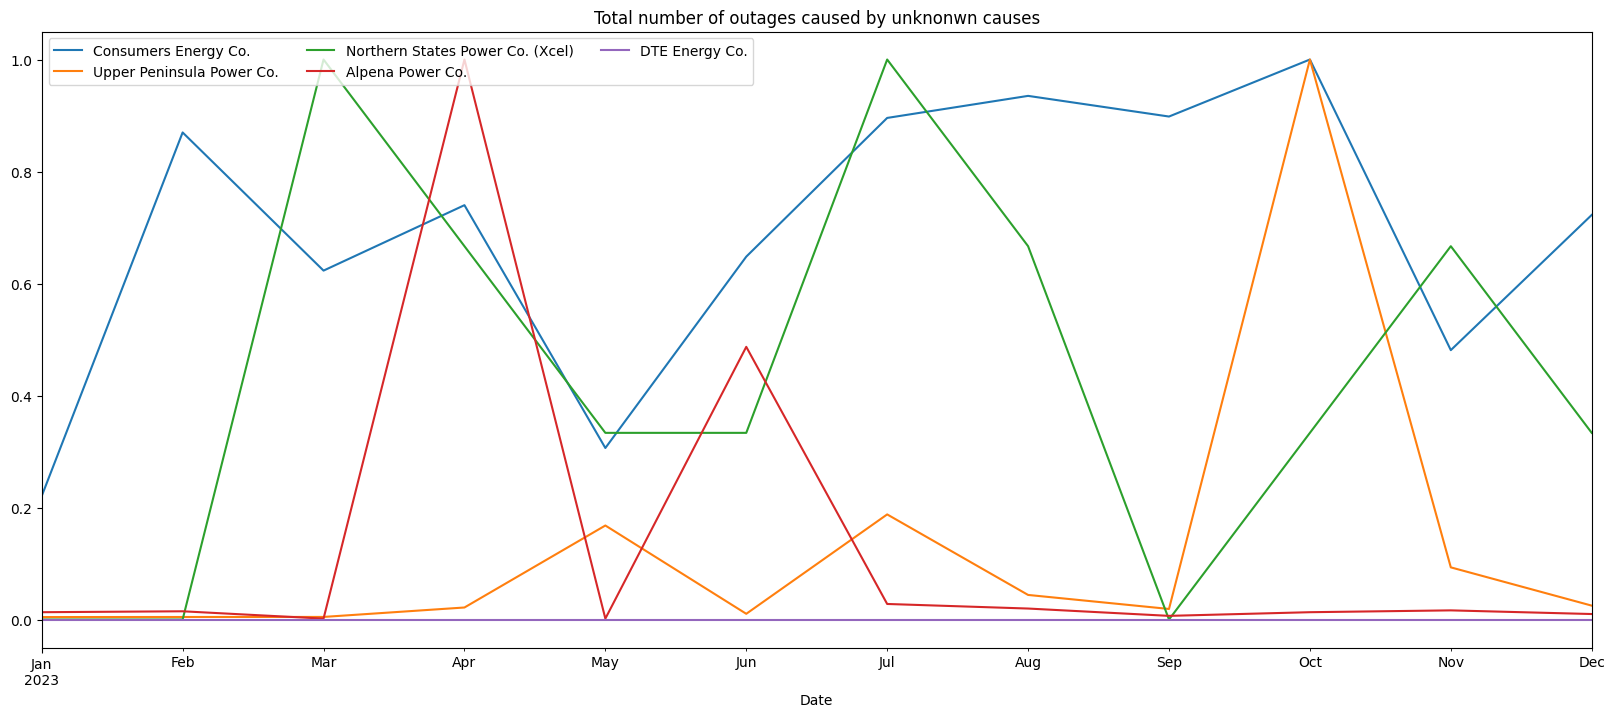

In [7]:
"""
This code snippet visualizes a specific reliability index for different energy systems. It normalizes the data and plots it for each system.

Explanation:
1. The dictionary `fields` maps field IDs to their corresponding descriptions.
2. The variable `field_to_analyze` is set to the description of the reliability index to be analyzed (e.g., SAIFI).
3. A plot is created for each energy system, showing the normalized values of the specified reliability index.
4. The y-axis represents the normalized index values (scaled to a maximum of 1).

Note:
- Adjust the field descriptions and column names according to your specific data.
"""

field_to_analyze: str = fields.get(10)

plt.figure(figsize=(20, 8))

for i in data_co["System"].value_counts().index:
    (data_co[data_co["System"] == i][field_to_analyze] / (data_co[data_co["System"] == i][field_to_analyze].max() or 1)).plot(label=i)
    plt.legend(ncol=3)
    plt.title(label=field_to_analyze)

Text(0.5, 1.0, 'NII-1')

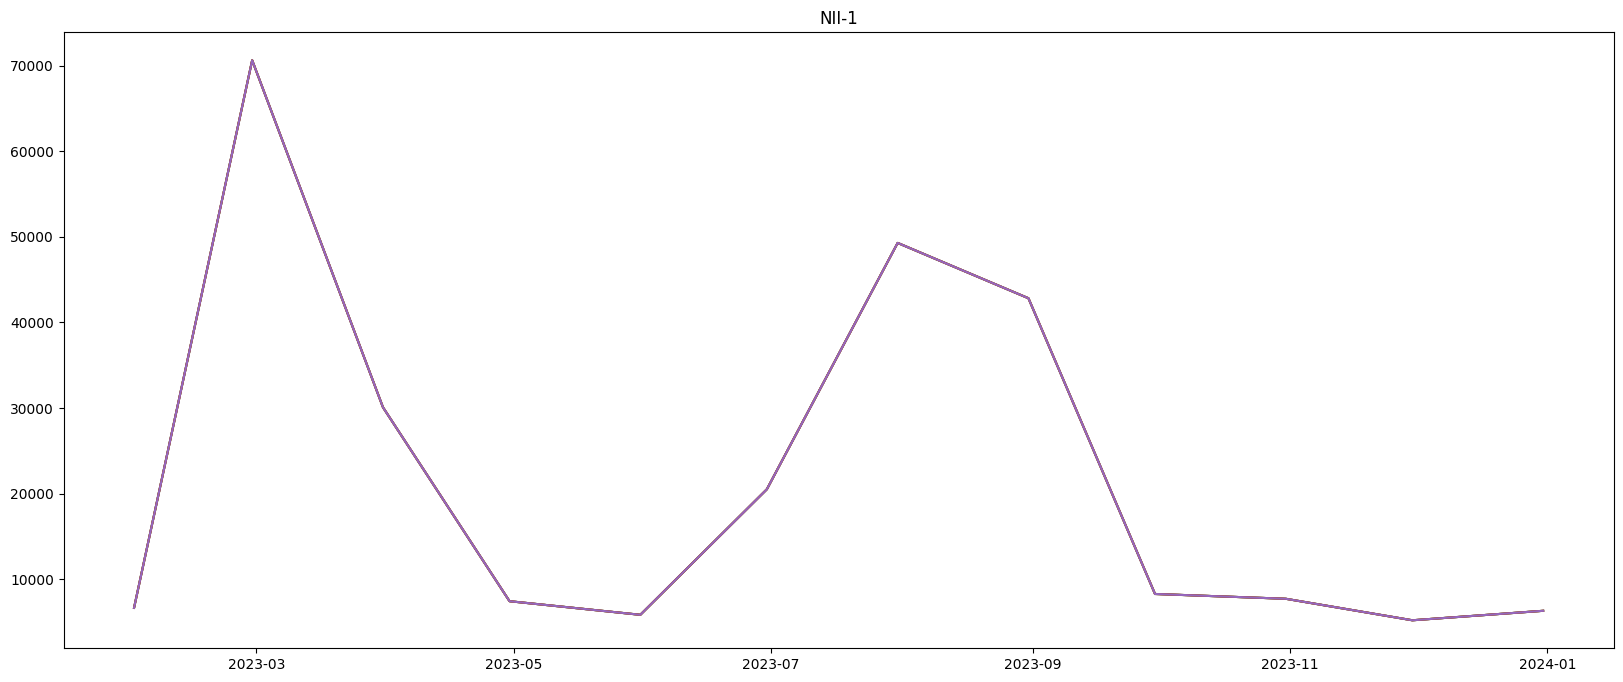

In [10]:
"""
This code snippet visualizes a specific field for different unique dates in the data. It normalizes the data and plots it for each date.

Explanation:
1. The variable `field_to_analyze` is set to the field to be analyzed (in this case, the last name of the employee).
2. A figure with a specific size for the plot is created.
3. An empty list is initialized to store the calculated values for each unique date.
4. For each unique date in the index of `data_co`, the values of the specified field are divided by the maximum value of that field on the same date (or 1 if the maximum value is 0), and the sum of these values is calculated and added to the list.
5. A line plot is drawn with the unique dates on the x-axis and the calculated values on the y-axis.
6. The title of the plot is set to the name of the field being analyzed.
"""

field_to_analyze: str = fields.get(16)

plt.figure(figsize=(20, 8))

y_values = []
for date in data_co.index.unique():
    value = sum(data_co[data_co.index == date][field_to_analyze]) / data_co['System'].value_counts() # Average
    # value = sum(data_co[data_co.index == date][field_to_analyze] / (data_co[data_co.index == date][field_to_analyze].max() or 1)) # "Weighted sum"
    y_values.append(value)

plt.plot(data_co.index.unique(), y_values)
plt.title(label=field_to_analyze)

In [11]:
try:
    raw_data = pd.read_csv(os.getenv('FILE_PATH_OMNI'), delimiter=" +", names=range(55), engine="python")
except:
    print("<Exception> OMNI File required")
    exit(0)

In [12]:
"""
This code snippet filters and processes data from a DataFrame. It selects specific columns based on their indices and restricts the data to a specific date range.

Explanation:
1. The DataFrame `raw_data` contains columns with indices 0, 1, 2, 38, 39, 40, 49, 50, 22, 23, 24, 27, 28, and 8.
2. The minimum and maximum dates from the DataFrame `filtered_df` are determined.
3. The years corresponding to these dates are extracted using `pd.Timestamp`.
4. The data is filtered to include only rows where the year (column 0) falls within the specified date range.
5. Column names are assigned to the processed data for better readability.

Note:
- Adjust column indices and date range according to your specific data.
"""

data_omni = raw_data[[0, 1, 2, 38, 39, 40, 49, 50, 22, 23, 24, 27, 28, 8]]
min_date, max_date = data_co.index.min(), data_co.index.max()
min_date_year, max_date_year = pd.Timestamp(min_date).year, pd.Timestamp(max_date).year
filtered_data_omni = data_omni[(data_omni[0] >= min_date_year) & (data_omni[0] <= max_date_year)]

filtered_data_omni.columns = [
    "Year", # 
    "DecimalYear", #
    "Hour", #
    "Kp", #
    "R", #
    "DST", #
    "Ap", #
    "F10.7", #
    "Proton temperature", #
    "Proton density", #
    "Plasma speed", #
    "Alpha/Proton ratio", #
    "Flow Pressure", #
    "Field Magnitude Average |B|" #
]

filtered_data_omni.index = pd.date_range(str(min_date_year), str(max_date_year + 1), freq="60min")[:-1]

filtered_data_omni = filtered_data_omni[["Kp", "R", "DST", "Ap", "F10.7", "Proton temperature", "Proton density", "Plasma speed", "Alpha/Proton ratio", "Flow Pressure", "Field Magnitude Average |B|"]]

In [13]:
"""
Explanation:
1. The DataFrame `data` contains columns that need cleaning.
2. We create a list of column names to process.
3. For each column, we replace specific values with NaN using `np.where`.

Note:
- Adjust column names and replacement values according to your specific data.
"""

columns_to_clean = [
    "F10.7",
    "Kp",
    "R",
    "DST",
    "Ap",
    "Proton temperature",
    "Proton density",
    "Plasma speed",
    "Alpha/Proton ratio",
    "Flow Pressure",
    "Field Magnitude Average |B|"
]

for col in columns_to_clean:
    filtered_data_omni[col] = np.where(filtered_data_omni[col] == 999.9, np.nan,filtered_data_omni[col])
    filtered_data_omni[col] = np.where(filtered_data_omni[col] == 99, np.nan, filtered_data_omni[col])
    filtered_data_omni[col] = np.where(filtered_data_omni[col] == 999, np.nan, filtered_data_omni[col])

In [14]:
filtered_data_omni = filtered_data_omni[(filtered_data_omni.index >= str(min_date_year))]

In [15]:
def create_columns(df: pd.DataFrame, new_columns: typing.List[str]) -> pd.DataFrame:
    """
    Creates new columns in a DataFrame and fills them with zeros.

    Args:
        df (pd.DataFrame): The DataFrame to add columns to.
        new_columns (typing.List[str]): A list of names for the new columns.

    Returns:
        pd.DataFrame: The DataFrame with the new columns added.
    """

    df[new_columns] = np.zeros((len(df), len(new_columns)))
    return df

In [16]:
df_kp = create_columns(df=filtered_data_omni.copy(), new_columns=['G0', 'G1 ', 'G2', 'G3', 'G4', 'G5'])
df_dst = create_columns(df=filtered_data_omni.copy(), new_columns=['Weak', 'Moderate', 'Intense', 'Severe'])

In [17]:
conditions_kp: typing.Dict[str, pd.Series] = {
    'G0': filtered_data_omni['Kp'].le(43),
    'G1': filtered_data_omni['Kp'].between(46, 54),
    'G2': filtered_data_omni['Kp'].between(56, 64),
    'G3': filtered_data_omni['Kp'].between(66, 74),
    'G4': filtered_data_omni['Kp'].between(76, 88),
    'G5': filtered_data_omni['Kp'].ge(90)
}
 
for G, condition in conditions_kp.items():
    df_kp[G] = condition

In [18]:
conditions_dst: typing.Dict[str, pd.Series] = {
    'Weak': filtered_data_omni['DST'].between(-50, -30, inclusive='right'),
    'Moderate': filtered_data_omni['DST'].between(-100, -50, inclusive='right'),
    'Intense': filtered_data_omni['DST'].between(-200, -100, inclusive='right'),
    'Severe': filtered_data_omni['DST'].le(-200)
}

for G, condition in conditions_dst.items():
    df_dst[G] = condition

In [19]:
def resample_kp(df: pd.DataFrame, lvl, closed: bool = None) -> pd.DataFrame:
    df_resampled_kp: pd.DataFrame = df.resample(rule=lvl, closed=closed).agg({
        'Kp': 'max',
        'R': 'mean',
        'F10.7': 'mean',
        'Proton temperature': 'mean',
        'Proton density': 'mean',
        'Plasma speed': 'mean',
        'Alpha/Proton ratio': 'mean',
        'Flow Pressure': 'mean',
        'Field Magnitude Average |B|': 'mean',
        'G1': 'sum',
        'G1': 'sum',
        'G2': 'sum',
        'G3': 'sum',
        'G4': 'sum',
        'G5': 'sum'
    })

    df_resampled_kp['Total ST'] = df_resampled_kp[['G1', 'G2', 'G3', 'G4', 'G5']].sum(axis=1)
    return df_resampled_kp

In [26]:
def resample_dst(df: pd.DataFrame, lvl, closed: bool = None) -> pd.DataFrame:
    df_resampled_dst: pd.DataFrame = df.resample(rule=lvl, closed=closed).agg({
        'DST': 'max',
        'R': 'mean',
        'F10.7': 'mean',
        'Proton temperature': 'mean',
        'Proton density': 'mean',
        'Plasma speed': 'mean',
        'Alpha/Proton ratio': 'mean',
        'Flow Pressure': 'mean',
        'Field Magnitude Average |B|': 'mean',
        'Weak': 'sum',
        'Moderate': 'sum',
        'Intense': 'sum',
        'Severe': 'sum'
    })

    df_resampled_dst['Total ST'] = df_resampled_dst[['Weak', 'Moderate', 'Intense', 'Severe']].sum(axis=1)
    return df_resampled_dst

In [21]:
freq: str = "ME"

In [22]:
df_resample_kp: pd.DataFrame = resample_kp(df_kp, freq)
df_resample_kp['Solar Cycle'] = pd.cut(df_resample_kp.index, 
                                        bins=[
                                            pd.to_datetime('1964-10-01'),
                                            pd.to_datetime('1976-03-01'),
                                            pd.to_datetime('1986-09-01'),
                                            pd.to_datetime("1996-08-01"), 
                                            pd.to_datetime("2008-12-31"),
                                            pd.to_datetime("2019-12-31"), 
                                            pd.to_datetime("2100-01-01")
                                        ],
                                        labels=[20, 21, 22, 23, 24, 25])

df_resample_kp = df_resample_kp.rename(columns={"Kp": "Kp max"})

df_resample_dst: pd.DataFrame = resample_dst(df_dst, freq)
df_resample_dst['Solar Cycle'] = pd.cut(df_resample_dst.index, 
                                        bins=[
                                            pd.to_datetime('1964-10-01'),
                                            pd.to_datetime('1976-03-01'),
                                            pd.to_datetime('1986-09-01'),
                                            pd.to_datetime("1996-08-01"), 
                                            pd.to_datetime("2008-12-31"),
                                            pd.to_datetime("2019-12-31"), 
                                            pd.to_datetime("2100-01-01")
                                        ],
                                        labels=[20, 21, 22, 23, 24, 25])

df_resample_dst = df_resample_dst.rename(columns={"DST": "DST max"})

In [39]:
def assign_columns(src: pd.DataFrame, target: pd.DataFrame,columns_to_assign: typing.List[str]) -> pd.DataFrame:
    for col in columns_to_assign:
        target = target.assign(**{col.strip(): src[col.strip()].astype(float)})

    return target

In [40]:
df_kp_resampled = assign_columns(src=df_resample_kp.copy(), target=df_kp, columns_to_assign=['Total ST', 'G1', 'G2', 'G3', 'G4', 'G5'])
df_dst_resampled = assign_columns(src=df_resample_dst.copy(), target=df_dst,columns_to_assign=['Total ST', 'Weak', 'Moderate', 'Intense', 'Severe'])

In [42]:
df_kp_resampled.to_excel('df_dst.xlsx')

In [ ]:
plt.scatter(c1_CEC['Total ST'], c1_CEC[field_to_analyze])

In [ ]:
plt.figure(figsize=(20, 4))
(c1_CEC[field_to_analyze] / c1_CEC[field_to_analyze].max()).plot()
(c1_CEC['Total ST'] / c1_CEC['Total ST'].max()).plot()
plt.legend(ncol=3)
plt.title(label=f"Total Storms vs {field_to_analyze}")

In [ ]:
np.corrcoef(np.array(c1_CEC[field_to_analyze]).astype(dtype=float), np.array(c1_CEC['Total ST']).astype(dtype=float))

In [ ]:
c1_CEC.corr(numeric_only=True)